## Load data

In [59]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = '/media/windows-share/EEGs_Guinea-Bissau_np/'

In [5]:
condition = '_10seconds_closed.npy'
X_train = np.load(datapath+'X_train'+condition)
y_train = np.load(datapath+'y_train'+condition)
X_val = np.load(datapath+'X_valid'+condition)
y_val = np.load(datapath+'y_valid'+condition)
X_test = np.load(datapath+'X_test'+condition)
y_test = np.load(datapath+'y_test'+condition)

In [6]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

{'Control': 0, 'Epilepsy': 1}


In [7]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_test], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [8]:
y_val_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [9]:
num_classes = y_train_binary.shape[1]
print(num_classes)

2


## Generate models

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [11]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [12]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 5,
                                  model_type = None)

CPU times: user 3.49 s, sys: 257 ms, total: 3.75 s
Wall time: 4.6 s


In [13]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([46, 58, 46]), 'fc_hidden_nodes': 11, 'learning_rate': 0.0002639441601955322, 'regularization_rate': 0.00528076140668184}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution1d_1 (Convolution1D)    (None, 1280, 46)    1978        convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)    (None, 1280, 58)    8062        convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 1280, 58)    0           convolution1d_2[0][0]            
____________________________________________________________________________________________________
convolution1d_3 (Convolution1D)    (None, 1280, 46) 

## Compare models

In [14]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subsize_set=200,
                                                                                  verbose=True)

Train on 108 samples, validate on 20 samples
Epoch 1/5
108/108 [==============================] - 1s - loss: 9.8744 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/5
108/108 [==============================] - 1s - loss: 9.8270 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/5
108/108 [==============================] - 2s - loss: 6.8046 - acc: 0.5833 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 4/5
108/108 [==============================] - 1s - loss: 6.4974 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 5/5
108/108 [==============================] - 1s - loss: 6.4879 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Train on 108 samples, validate on 20 samples
Epoch 1/5
108/108 [==============================] - 90s - loss: 0.7589 - acc: 0.4722 - val_loss: 0.6825 - val_acc: 0.5500
Epoch 2/5
108/108 [==============================] - 95s - loss: 0.7275 - acc: 0.6019 - val_loss: 0.7029 - val_acc: 0.5500
Epoch 3/5
108/108 [==============================] - 9

CPU times: user 499 ms, sys: 7.11 ms, total: 506 ms
Wall time: 535 ms


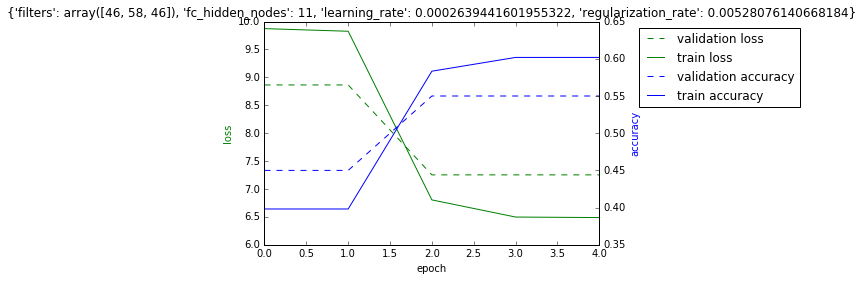

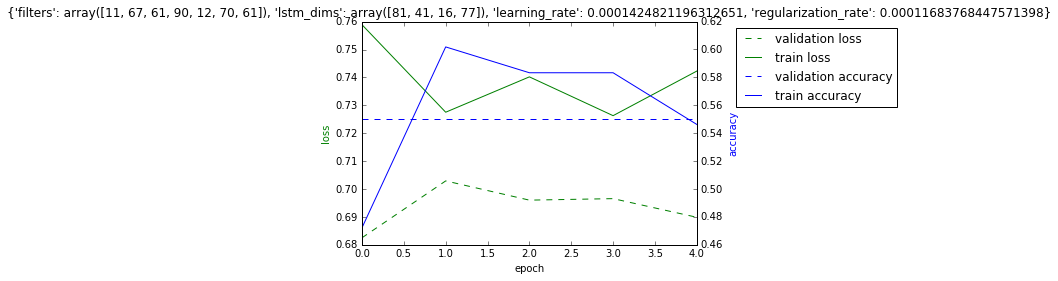

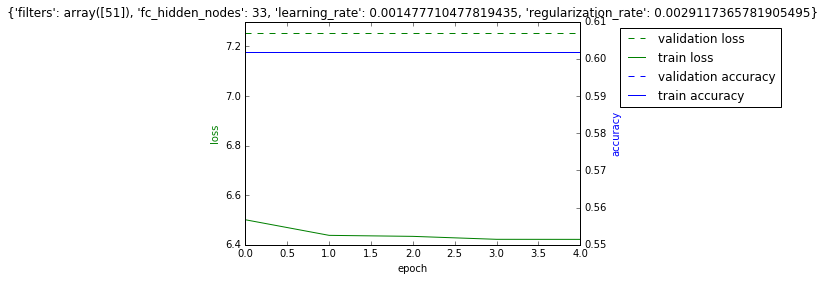

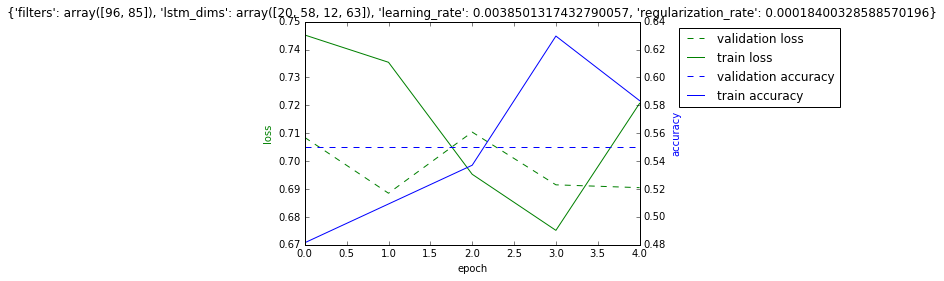

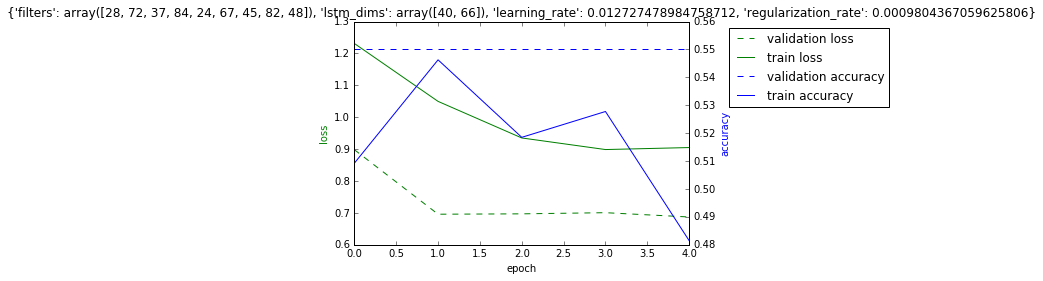

In [15]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [16]:
%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

CPU times: user 78.7 ms, sys: 101 ms, total: 180 ms
Wall time: 336 ms


In [21]:
models

[(<keras.models.Sequential at 0x7f57d03b54e0>,
  {'fc_hidden_nodes': 11,
   'filters': array([46, 58, 46]),
   'learning_rate': 0.0002639441601955322,
   'regularization_rate': 0.00528076140668184},
  'CNN'),
 (<keras.models.Sequential at 0x7f57ca6e8c18>,
  {'filters': array([11, 67, 61, 90, 12, 70, 61]),
   'learning_rate': 0.0001424821196312651,
   'lstm_dims': array([81, 41, 16, 77]),
   'regularization_rate': 0.00011683768447571398},
  'DeepConvLSTM'),
 (<keras.models.Sequential at 0x7f57c9c7f5f8>,
  {'fc_hidden_nodes': 33,
   'filters': array([51]),
   'learning_rate': 0.001477710477819435,
   'regularization_rate': 0.0029117365781905495},
  'CNN'),
 (<keras.models.Sequential at 0x7f57c9c31048>,
  {'filters': array([96, 85]),
   'learning_rate': 0.0038501317432790057,
   'lstm_dims': array([20, 58, 12, 63]),
   'regularization_rate': 0.00018400328588570196},
  'DeepConvLSTM'),
 (<keras.models.Sequential at 0x7f57c974c2b0>,
  {'filters': array([28, 72, 37, 84, 24, 67, 45, 82, 48]),

## Train the best model for real

In [22]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [23]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'filters': array([46, 58, 46]), 'fc_hidden_nodes': 11, 'learning_rate': 0.0002639441601955322, 'regularization_rate': 0.00528076140668184}


In [24]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 2s - loss: 6.4829 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 2/10
108/108 [==============================] - 2s - loss: 6.4802 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 3/10
108/108 [==============================] - 2s - loss: 6.4782 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 4/10
108/108 [==============================] - 2s - loss: 6.4765 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 5/10
108/108 [==============================] - 2s - loss: 6.4751 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 6/10
108/108 [==============================] - 2s - loss: 6.4739 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 7/10
108/108 [==============================] - 1s - loss: 6.4727 - acc: 0.6019 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 8/10
108/108 [==============================] - 2s - loss: 6.4716 - acc: 0.6019 - val_lo

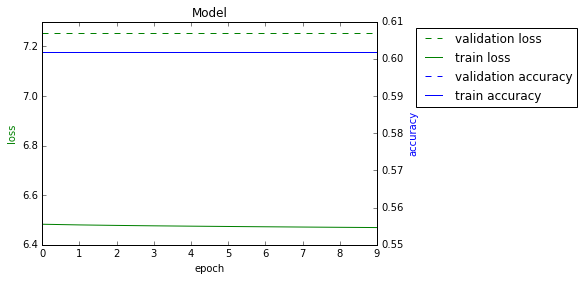

In [25]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [112]:
datasize = X_val.shape[0]
best_model.predict_proba(X_val[:datasize,:,:],batch_size=1)

108/108 [==============================] - 1s     


array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,

In [63]:
best_model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution1d_1 (Convolution1D)    (None, 1280, 46)    1978        convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)    (None, 1280, 58)    8062        convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 1280, 58)    0           convolution1d_2[0][0]            
____________________________________________________________________________________________________
convolution1d_3 (Convolution1D)    (None, 1280, 46)    8050        activation_1[0][0]               
___________________________________________________________________________________________

In [109]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([best_model.layers[0].input],
                                  [best_model.layers[7].output])
layer_output = get_3rd_layer_output([X_val])[0]

In [110]:
layer_output.shape

(20, 11)

In [111]:
layer_output

array([[  0.00000000e+00,   2.02582812e+03,   9.16869521e-01,
          2.00475659e+03,   2.49831796e+00,   2.36123943e+00,
         -2.12934683e-05,   3.63028193e+00,   3.49624991e+00,
          1.67400265e+00,  -2.12926534e-05],
       [  0.00000000e+00,   1.70265503e+03,   9.24118817e-01,
          1.69453125e+03,   2.16413307e+00,   1.88457394e+00,
         -2.12934683e-05,   2.93311787e+00,   3.16785622e+00,
          1.54145873e+00,  -2.12926534e-05],
       [  0.00000000e+00,   1.69119336e+03,   8.95727754e-01,
          1.68286450e+03,   2.16958737e+00,   1.88280547e+00,
         -2.12934683e-05,   2.91613340e+00,   3.14395332e+00,
          1.54159498e+00,  -2.12926534e-05],
       [  0.00000000e+00,   1.65089136e+03,   8.92510414e-01,
          1.64534326e+03,   2.16411734e+00,   1.82724583e+00,
         -2.12934683e-05,   2.92032123e+00,   3.18596649e+00,
          1.51596081e+00,  -2.12926534e-05],
       [  0.00000000e+00,   1.70529346e+03,   8.73303711e-01,
          1.69

In [107]:
y_val_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]